## Charaterize the difference among bioethanol vs human vs wild type strains according transcriptome integrated fluxes data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import umap
import os

os.chdir(r'D:\code\github\Unified_Yeast_GEMs_Database_from_13pro\Unified_Yeast_GEMs_Database')

In [5]:
# load strain type infomation
df_strain_info=pd.read_csv('data/1892_strains_info.csv',index_col=0)
human_strainList=df_strain_info[df_strain_info['nature_clade']=='10. French Guiana human '].index.tolist()
wt_strainList=df_strain_info[df_strain_info['nature_clade'].isin(['14. CHNIII ','20. CHN V ', '15. CHNII ','17. Taiwanese ', '24. Asian islands ', '18. Far East Asia ', '19. Malaysian ', '22. Far East Russian '])].index.tolist()
bioethanol_strainList=df_strain_info[df_strain_info['nature_clade']=='3. Brazilian bioethanol '].index.tolist()


In [6]:
# load pathway information
df_r_tpmfc_fluxfc=pd.read_csv('code/7.transcriptomics_ssGEMs_analysis/output/pearson_tpmfc_fluxfc.csv',index_col=0)
# only keep rxn p value less than 0.05
df_r_tpmfc_fluxfc = df_r_tpmfc_fluxfc[df_r_tpmfc_fluxfc['p_value']<0.05]
# remove rxns with pearson correlation coefficient <0
df_r_tpmfc_fluxfc = df_r_tpmfc_fluxfc[df_r_tpmfc_fluxfc['pearson correlation coefficient']>0]
# df_r_tpmfc_fluxfc groupby subsystem, and sort by the number of rxns in each subsystem
df_subsystem_tpm_flux = df_r_tpmfc_fluxfc.groupby('subsystem').count()
# calculate mean pearson correlation coefficient for each subsystem
df_subsystem_tpm_flux['mean_pearson'] = df_r_tpmfc_fluxfc.groupby('subsystem')['pearson correlation coefficient'].mean()
df_subsystem_tpm_flux['p_value']=df_r_tpmfc_fluxfc.groupby('subsystem')['p_value'].mean()
df_subsystem_tpm_flux = df_subsystem_tpm_flux.sort_values(by='mean_pearson', ascending=False)
# remove out subsystems which have less than 5 rxns
df_subsystem_tpm_flux = df_subsystem_tpm_flux[df_subsystem_tpm_flux['pearson correlation coefficient']>5]
check_subsystemList = df_subsystem_tpm_flux.index.tolist()
# remove Transport
check_subsystemList=[i for i in check_subsystemList if 'Transport' not in i]
check_rxnList=df_r_tpmfc_fluxfc[df_r_tpmfc_fluxfc['subsystem'].isin(check_subsystemList)].index.tolist()


### 1. Cluster by fluxes data

In [7]:
def umap_cluster(raw_data,data_type,emetric="euclidean",n_neighbors=15,min_dist=0.1,n_components=2):
    # data归一化
    data = raw_data.iloc[:,:-1]
    data = StandardScaler().fit_transform(data)
    data = pd.DataFrame(data, index=raw_data.index, columns=raw_data.columns[:-1])
    #UMAP降维
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, metric=emetric)
    embedding = reducer.fit_transform(data)
    df_embedding = pd.DataFrame(embedding, index=raw_data.index, columns=["UMAP1", "UMAP2"])
    df_embedding["label"]=raw_data["label"]
    # plot UMAP
    sns.scatterplot(
        x="UMAP1", y="UMAP2",
        hue="label",
        data=df_embedding,
        legend="full",
        alpha=0.8
    )
    plt.title("Sce strains clustering by %s"%data_type)
    plt.show()
    return embedding

In [8]:
# load flux data
df_fluxes_data=pd.read_csv('code/7.transcriptomics_ssGEMs_analysis/output/PNAS_v3_tissGEMs_sample_flux.csv',index_col=0)
# remove columns with 0 value in growth row
df_fluxes_data=df_fluxes_data.loc[df_fluxes_data.index.isin(check_rxnList),:]

# extract check rxns fluxes data
df_target_fluxes_data=df_fluxes_data.loc[check_rxnList,:]

# extract bioethanol, human and wt strains fluxes data and label them
df_target_fluxes_data=df_target_fluxes_data.T
df_target_fluxes_data.loc[df_target_fluxes_data.index.isin(bioethanol_strainList),'label']='bioethanol'
df_target_fluxes_data.loc[df_target_fluxes_data.index.isin(human_strainList),'label']='human'
df_target_fluxes_data.loc[df_target_fluxes_data.index.isin(wt_strainList),'label']='wt'
# remove nan value in type column
df_target_fluxes_data=df_target_fluxes_data.dropna(subset=['label'])
#fill Nan value with 0
df_target_fluxes_data=df_target_fluxes_data.fillna(0)
# remove columns with all 0 value
df_target_fluxes_data=df_target_fluxes_data.loc[:, (df_target_fluxes_data != 0).any(axis=0)]
# remove columns with any value more than 10
label=df_target_fluxes_data['label']
df_target_fluxes_data=df_target_fluxes_data.iloc[:,:-1].loc[:, (df_target_fluxes_data.iloc[:,:-1] <= 10).all(axis=0)]
df_target_fluxes_data['label']=label.values


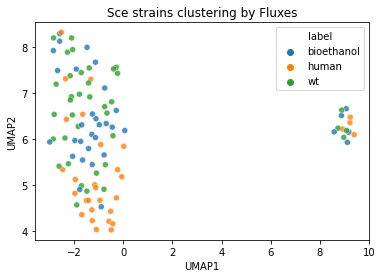

In [9]:
fluxes_embedding=umap_cluster(raw_data=df_target_fluxes_data,
                              data_type='Fluxes')

### 2.Random forest classification learn the difference among bioethanol vs human vs wild type

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [11]:
def random_forest():
    parameters = {
                    'max_features':np.arange(0.1,1.1,0.1),'n_estimators':[10,100,500,1000]
    }
    rf = RandomForestClassifier()
    model=GridSearchCV(rf,parameters,n_jobs=1,cv=3)      #optimize the parameters
    return model

def do_cross_validation(X,y,model):
    '''do cross validation to evaluate the model'''
    scores = cross_val_score(model,X,y,scoring='accuracy',cv=5,n_jobs=1)
    return scores

In [12]:
# train random forest model
y=list(df_target_fluxes_data["label"])
y = np.array(y)
X = df_target_fluxes_data.drop(columns=["label"]).values
model = random_forest()
model.fit(X,y)
result=do_cross_validation(X,y,model)
print(model.best_params_)
print(model.best_score_)

{'max_features': 0.5, 'n_estimators': 1000}
0.6913250148544267


In [13]:
# get the feature importance
feature_importance = model.best_estimator_.feature_importances_
feature_importance = pd.DataFrame(feature_importance,index=df_target_fluxes_data.drop(columns=["label"]).columns,columns=["importance"])
feature_importance.sort_values(by="importance",ascending=False,inplace=True)
feature_importance=feature_importance["importance"]


87


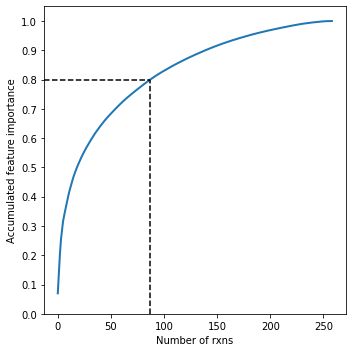

In [14]:
# plot accumulation curve
plt.figure(figsize=(5,5))
percent = 0.8
acc = []
top_num = 0
for i in range(len(feature_importance)):
    summ = np.sum(feature_importance[:i+1])
    if summ >= percent and top_num==0:
        top_num = i
        print(top_num)
    acc.append(summ)
plt.plot(np.arange(len(acc)),acc,linewidth=2)
ylim = [0,1.05]
xlim = plt.gca().get_xlim()
plt.plot([top_num,top_num],[0,percent],'k--')
plt.plot([xlim[0],top_num],[percent,percent],'k--')
plt.xlim(xlim)
plt.ylim(ylim)
plt.yticks(np.arange(0,1.1,0.1))
plt.xlabel('Number of rxns')
plt.ylabel('Accumulated feature importance')
plt.tight_layout()
plt.show()

In [21]:
# feature gene functional enrichment
feature_rxns =feature_importance[:top_num].index.tolist()

feature_rxns_info= df_r_tpmfc_fluxfc.loc[feature_rxns,:]
pathway_count=pd.DataFrame(feature_rxns_info['subsystem'].value_counts().values,columns=['feature_rxns'],index=feature_rxns_info['subsystem'].value_counts().index.tolist())
pathway_count['Total']=df_r_tpmfc_fluxfc['subsystem'].value_counts()[pathway_count.index.tolist()]
pathway_count


,feature_rxns,Total
Glycolysis / gluconeogenesis,10,13
"Phenylalanine, tyrosine and tryptophan biosynthesis",8,13
Glycerolipid metabolism,7,16
Citrate cycle (TCA cycle),7,10
Arginine biosynthesis,7,7
Starch and sucrose metabolism,6,10
Glycerophospholipid metabolism,6,28
Purine metabolism,6,21
Pyrimidine metabolism,5,13
Pyruvate metabolism,4,6


C:\Users\wangh\AppData\Local\Temp\ipykernel_8388\3786406269.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feature_fluxes_data['label']=label.values


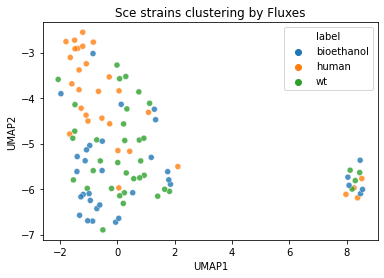

In [16]:
# cluster according to the feature rxns
df_feature_fluxes_data=df_target_fluxes_data[feature_rxns]
df_feature_fluxes_data['label']=label.values

fluxes_embedding=umap_cluster(raw_data=df_feature_fluxes_data,
                                data_type='Fluxes')